# Visualization of the PyTorch graph with bad gradients

These days, the [autograd anomaly detection](https://pytorch.org/docs/stable/autograd.html#anomaly-detection) is the canonical way to detect bad gradients.

From the early days of PyTorch, though, there has been a [script by Adam Paszke](https://gist.github.com/apaszke/f93a377244be9bfcb96d3547b9bc424d) plotting a graph with bad gradient nodes marked in red. As it is still popular, I have modernized it here to work with recent versions of PyTorch.

Enjoy!


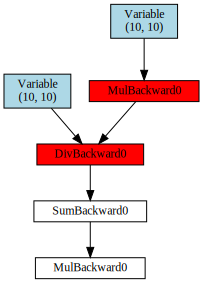

In [1]:
from graphviz import Digraph
import torch
from torch.autograd import Variable, Function

def iter_graph(root, callback):
    queue = [root]
    seen = set()
    while queue:
        fn = queue.pop()
        if fn in seen:
            continue
        seen.add(fn)
        for next_fn, _ in fn.next_functions:
            if next_fn is not None:
                queue.append(next_fn)
        callback(fn)

def register_hooks(var):
    fn_dict = {}
    def hook_cb(fn):
        def register_grad(grad_input, grad_output):
            fn_dict[fn] = grad_input
        fn.register_hook(register_grad)
    iter_graph(var.grad_fn, hook_cb)

    def is_bad_grad(grad_output):
        if grad_output is None:
            return False
        return grad_output.isnan().any() or (grad_output.abs() >= 1e6).any()

    def make_dot():
        node_attr = dict(style='filled',
                        shape='box',
                        align='left',
                        fontsize='12',
                        ranksep='0.1',
                        height='0.2')
        dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))

        def size_to_str(size):
            return '('+(', ').join(map(str, size))+')'

        def build_graph(fn):
            if hasattr(fn, 'variable'):  # if GradAccumulator
                u = fn.variable
                node_name = 'Variable\n ' + size_to_str(u.size())
                dot.node(str(id(u)), node_name, fillcolor='lightblue')
            else:
                assert fn in fn_dict, fn
                fillcolor = 'white'
                if any(is_bad_grad(gi) for gi in fn_dict[fn]):
                    fillcolor = 'red'
                dot.node(str(id(fn)), str(type(fn).__name__), fillcolor=fillcolor)
            for next_fn, _ in fn.next_functions:
                if next_fn is not None:
                    next_id = id(getattr(next_fn, 'variable', next_fn))
                    dot.edge(str(next_id), str(id(fn)))
        iter_graph(var.grad_fn, build_graph)

        return dot

    return make_dot

x = torch.randn(10, 10, requires_grad=True)
y = torch.randn(10, 10, requires_grad=True)

z = x / (y * 0)
z = z.sum() * 2
get_dot = register_hooks(z)
z.backward()
dot = get_dot()
#dot.save('tmp.dot') # to get .dot
#dot.render('tmp') # to get SVG
dot # in Jupyter, you can just render the variable